In [9]:
import numpy as np
import gym
import matplotlib.pyplot as plt
# gym initialization
env = gym.make('Pong-v0')
observation = env.reset()
prev_input = None
# Declaring the two actions that can happen in Pong for an agent, move up or move down
# Decalring 0 means staying still. Note that this is pre-defined specific to package.
UP_ACTION = 2
DOWN_ACTION = 3
# Hyperparameters. Gamma here allows you to measure the effect of future events
gamma = 0.99
# initialization of variables used in the main loop
x_train, y_train, rewards = [], [], []
reward_sum = 0
episode_num = 0


In [10]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6000 (75x80) 1D float vector """
    I = I[35:195] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
    I = I[::2,::2,0] # downsample by factor of 2.
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
    return I.astype(np.float).ravel() # ravel flattens an array and collapses it into a column vector





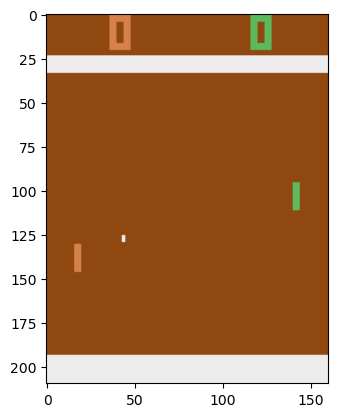

(array([0., 1.]), array([6366,   34]))


/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_18874/1888411344.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel() # ravel flattens an array and collapses it into a column vector


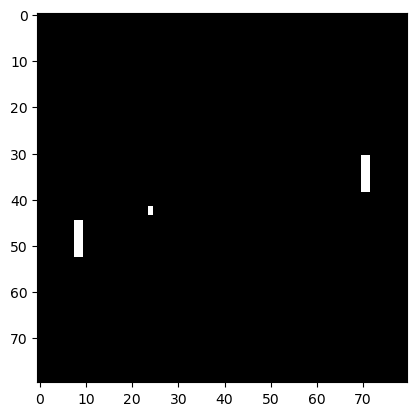

In [16]:
for i in range(22):
    if i > 20:
        plt.imshow(observation)
        plt.show() # before preprocessing
    observation, _, _, _ = env.step(1)
    
obs_preprocessed = prepro(observation).reshape(80,80)
print(np.unique(obs_preprocessed,return_counts=True)) # binary array
plt.imshow(obs_preprocessed, cmap='gray')
plt.show() # after preprocessing

In [12]:
def discount_rewards(r, gamma): # idea: 
    r = np.array(r)
    discounted_r = np.zeros(r.shape)
    running_add = 0
    print(discounted_r)

    for t in reversed(range(0, len(r))): 
        
        if r[t] != 0: running_add = 0 # if the game ended reset 
        running_add = running_add * gamma + r[t] 
        discounted_r[t] = running_add
        
    # not sure whether normalizing is helpful or not:
    
    # discounted_r -= np.mean(discounted_r) 
    # discounted_r /= np.std(discounted_r)
    
    
    return discounted_r

In [22]:
import keras

# layers
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Flatten

# models
from keras.models import Sequential, load_model

# optimizer 
from keras.optimizers import Adam # adaptive moment estimation, a type of stochastic gradient descent

# callback
from keras.callbacks import ModelCheckpoint



model = Sequential()
model.add(Dense(units=200,
                input_dim=80*80,
                activation='relu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(units=1,
                activation='sigmoid',
                kernel_initializer='RandomNormal'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath = 'dumb_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1)
callbacks_list = [checkpoint]


model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 200)               1280200   
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,280,401
Trainable params: 1,280,401
Non-trainable params: 0
_________________________________________________________________


In [20]:
a = [[1,2,3,4,5],[4,5,6,5,4], [7,7,7,7,7]]
print(np.vstack(a).T)

[[1 4 7]
 [2 5 7]
 [3 6 7]
 [4 5 7]
 [5 4 7]]


In [21]:
history = []
observation = env.reset() # initialize to first frame
prev_input = None

while(True):
    
    cur_input = prepro(observation) # frame preprocessed
    
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80) 
    
    prev_input = cur_input
    
    
    x = np.expand_dims(x, axis=1).T
    prob = model.predict(x, verbose=False)
    
    
    action = UP_ACTION if np.random.uniform() < prob else DOWN_ACTION # The neural net returns a probability
    
    y = 1 if action == 2 else 0 # converting between output of neural net and up/down action
    
    x_train.append(x)
    y_train.append(y)
    
    
    observation, reward, done, info = env.step(action) 
    
    rewards.append(reward)
    
    
    if done: # episode finished after 21 games are won by either player
        reward_sum = np.sum(rewards)
        history.append(reward_sum)
        print("Episode Number: ", episode_num, "| Total Reward: ", reward_sum)
        
        # x: image arrays, y=action performed, weights:
        
        disc = discount_rewards(rewards, gamma)
        print(disc)
            
        model.fit(x=np.vstack(x_train), 
                  y=np.vstack(y_train), 
                  sample_weight=disc,
                  verbose=0, callbacks=callbacks_list)
        
        
        x_train, y_train, rewards = [],[],[]
        observation = env.reset()

        episode_num += 1
        prev_input = None


/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_18874/1888411344.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel() # ravel flattens an array and collapses it into a column vector


Episode Number:  12 | Total Reward:  -32.0
[0. 0. 0. ... 0. 0. 0.]
[-0.42559012 -0.42988901 -0.43423133 ... -0.99       -1.
  0.        ]

Epoch 1: saving model to dumb_model.h5


KeyboardInterrupt: 

In [23]:
# loading the model
dumb_model = load_model(filepath)
print(dumb_model)